# Imports

In [132]:
import pandas as pd
import numpy as np
from collections import Counter
import string

import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from wordcloud import WordCloud

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [2]:
COLOR = '#62d197'

# EDA

## Import data

In [3]:
data = pd.read_csv('../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
print(f'This dataset has {df.shape[0]} rows and {df.shape[1]} columns')

This dataset has 1050 rows and 15 columns


## Duplicates

In [5]:
# Check for duplicates on uniq_id
duplicates = df.duplicated(subset='uniq_id')
print(f'This dataset has {duplicates.sum()} duplicates')

This dataset has 0 duplicates


## Missing values

In [5]:
# Get missing values
missing = df.isnull().sum()
print(f'This dataset has {missing.sum()} missing')
brands_missing = df['brand'].isnull().sum()
print(f'{brands_missing} missing values in the brand column')
retail_missing = df['retail_price'].isnull().sum()
print(f'{retail_missing} missing value in the retail_price column')
discount_missing = df['discounted_price'].isnull().sum()
print(f'{discount_missing} missing value in the discounted_price column')

This dataset has 341 missing
338 missing values in the brand column
1 missing value in the retail_price column
1 missing value in the discounted_price column


## Features selection

The objective is to suggest a classification in the appropriate category(ies) based on a product description and/or a product image. We will select the features according to this objective.

In [6]:
# Filter information
to_keep = ['uniq_id', 'product_name', 'product_category_tree', 'description', 'image']
print('As our goal is to create a classifier, we will keep only the following columns:')
for col in to_keep:
    print(f' - {col}')

As our goal is to create a classifier, we will keep only the following columns:
 - uniq_id
 - product_name
 - product_category_tree
 - description
 - image


In [7]:
df = df[to_keep]

## Category tree structure

In [8]:
# Get informations about category tree
df['product_category_tree'].apply(lambda x: x.split('>>')[0].replace('["','').replace(']','').strip()).value_counts()


product_category_tree
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [9]:
# Add a column main_category
df['main_category'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].replace('["','').replace(']','').strip())
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                  image    main_category  
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care  
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care  
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing  
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing

### Tree deepness

In [10]:
df_cat = df.copy()

def split_subcategories(product):
    cleaned = product.strip('["]').replace(' >> ', '>>')
    categories = cleaned.split('>>')
    return categories[:-1]

def extract_subcategories(row):
    categories = row.strip('["]').split(' >> ')
    sub_categories = ' '.join(categories[1:])  # Joindre toutes les sous-catégories en une seule chaîne
    return sub_categories

In [11]:
df_cat['subcategories'] = df_cat['product_category_tree'].apply(split_subcategories)
deep_max = max(df_cat['subcategories'].apply(len))
print(f'The maximum number of subcategories is {deep_max}')

for i in range(1, deep_max+1):
    df_cat[f'subcategory_{i}'] = df_cat['subcategories'].apply(lambda x: x[i] if i < len(x) else None)

df_cat.drop(columns=['product_category_tree', 'subcategories'], inplace=True)
df_cat.head()

The maximum number of subcategories is 6


uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                  image    main_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

            subcategory_1     subcategory_2                    subcategory_3  \
0  Curtains & Accessories          Curtains                             None   
1        Baby Bath & Skin  Baby Bath Towels        Sathiyas Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels         Eurospa Baby Bath Towels   
3               Bed Linen         Bedsheets  SANTOSH ROYAL FASHION Bedsheets   
4               Bed Linen         Bedsheets           Jaipur Print Bedsheets   

  subcategory_4 subcategory_5 subcategory_6  
0          None          None          None  
1          None          None          None  
2          None          None          None  
3          None          None          None  
4          None          None          None

In [12]:
categories = df['main_category'].unique()
for cat in categories:
    df_home_frunishing = df[df['main_category'] == cat]
    subcat = len(df_home_frunishing.apply(lambda x: x['product_category_tree'].split('>>')[1], axis=1).unique())
    print(f'{cat} has {subcat} sub categories')

Home Furnishing has 12 sub categories
Baby Care has 9 sub categories
Watches has 2 sub categories
Home Decor & Festive Needs has 10 sub categories
Kitchen & Dining has 11 sub categories
Beauty and Personal Care has 11 sub categories
Computers has 8 sub categories


In [13]:
# group by main category and get the number of product per unique subcategories
df_cat_grouped = df_cat.groupby(['main_category'])[['subcategory_1', 'subcategory_2','subcategory_3','subcategory_4','subcategory_5','subcategory_6']].count().reset_index()
df_cat_grouped.head(10)

main_category  subcategory_1  subcategory_2  subcategory_3  \
0                   Baby Care            150            150            111   
1    Beauty and Personal Care            150            129            116   
2                   Computers            150            148             40   
3  Home Decor & Festive Needs            149            114             61   
4             Home Furnishing            148             42             10   
5            Kitchen & Dining            150             86             66   
6                     Watches            150             10              1   

   subcategory_4  subcategory_5  subcategory_6  
0             87             56              0  
1             17              1              0  
2              1              0              0  
3              9              0              0  
4              0              0              0  
5             13              0              0  
6              0              0              0

In [14]:
df_cat.drop(columns=['subcategory_6'], inplace=True)

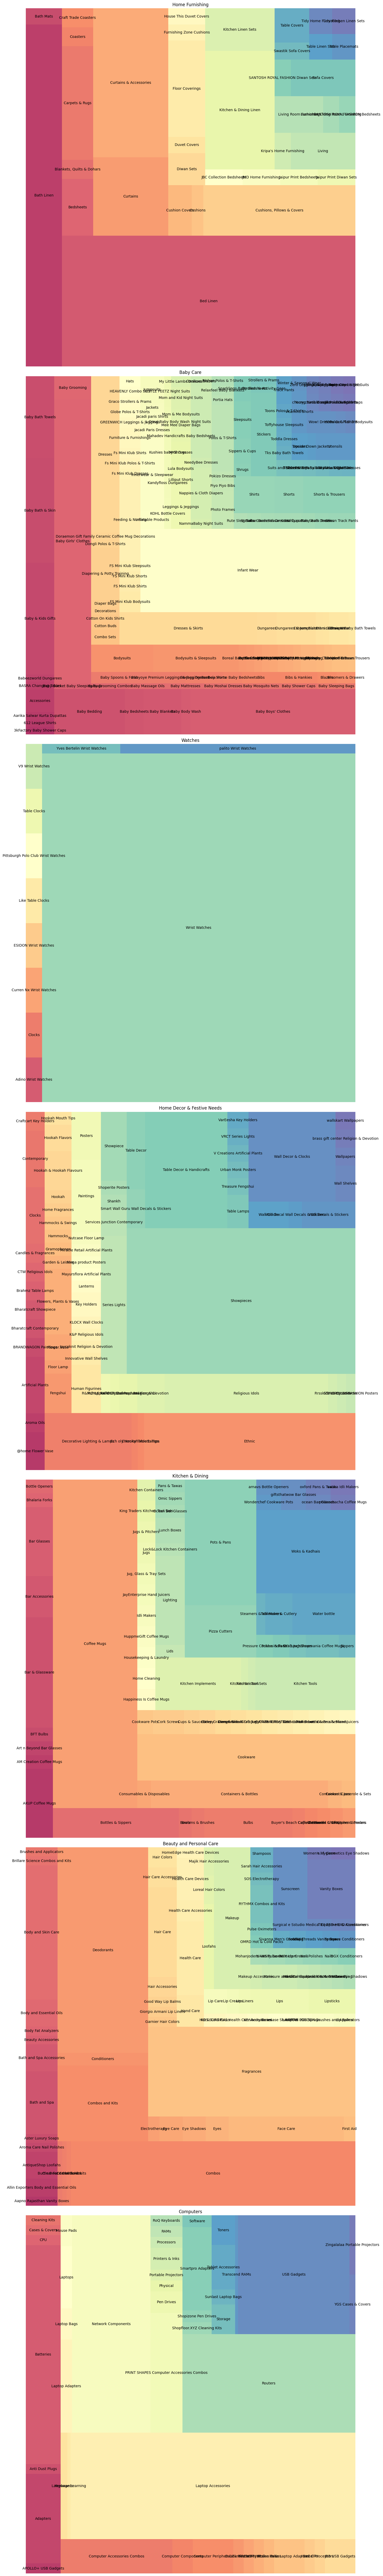

In [15]:
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 100))

for i, cat in enumerate(categories):
    filtered_df = df_cat[df_cat['main_category'] == cat]

    # Count each subcategory occurence for the category
    subcategory_count = filtered_df.filter(like='subcategory_').apply(pd.Series.value_counts).sum(axis=1)

    # Create a dataframe for the subcategories and their count
    subcategories_df = pd.DataFrame({'subcategory': subcategory_count.index, 'count': subcategory_count.values})

    # plot the tree
    squarify.plot(
        sizes=subcategories_df['count'],
        label=subcategories_df['subcategory'],
        alpha=.8,
        color=sns.color_palette("Spectral", len(subcategories_df['count'])),
        ax=axes[i],
        text_kwargs = {'fontsize': 10, 'color': 'black'},
        )
    axes[i].set_title(cat)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This tree map shows that the categories lack of homogeneity. They each have more a less children subcategories

In [16]:
df['children'] = df['product_category_tree'].apply(extract_subcategories)
df.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                  image    main_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                            children  
0  Curtains & Accessories Curtains Elegance Polye...  
1  Baby Bath & Skin Baby Bath Towels Sathiyas Bab...  
2  Baby Bath & Skin Baby Bath Towels Eurospa Baby...  
3  Bed Linen Bedsheets SANTOSH ROYAL FASHION Beds...  
4  Bed Linen Bedsheets Jaipur Print Bedsheets Jai...

In [17]:
# drop tree column
df = df.drop(columns='product_category_tree')

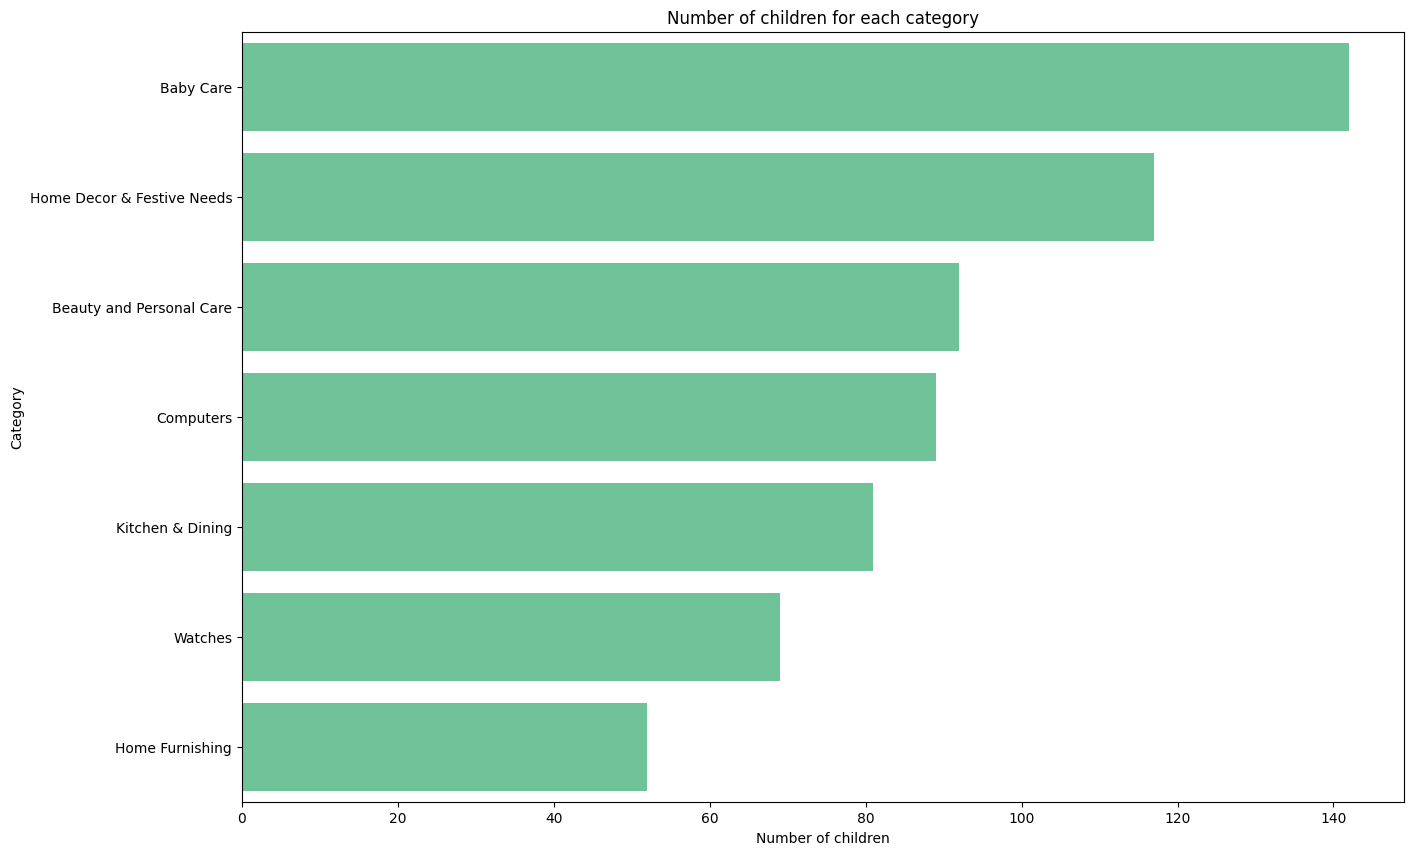

In [142]:
# Plot the number of children for each category
df_grouped = df.groupby('main_category')['children'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x=df_grouped.values, y=df_grouped.index, color=COLOR)
plt.title('Number of children for each category')
plt.xlabel('Number of children')
plt.ylabel('Category')
plt.show()


## Product description

In [18]:
# Normalize description to lowercase
df['description'] = df['description'].str.lower()

In [19]:
# Count number of characters in description
df['description_length'] = df['description'].apply(lambda x: len(x))
df['description_length'].describe()

count    1050.000000
mean      473.820952
std       457.910422
min       109.000000
25%       192.000000
50%       278.000000
75%       588.250000
max      3490.000000
Name: description_length, dtype: float64

In [20]:
# How many sentences in a description.
# A sentence starts with a capital letter and ends with a dot.
df['description_sentences'] = df['description'].apply(lambda x: len(x.split('.')))
df['description_sentences'].describe()

count    1050.000000
mean        6.604762
std         4.655836
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        44.000000
Name: description_sentences, dtype: float64

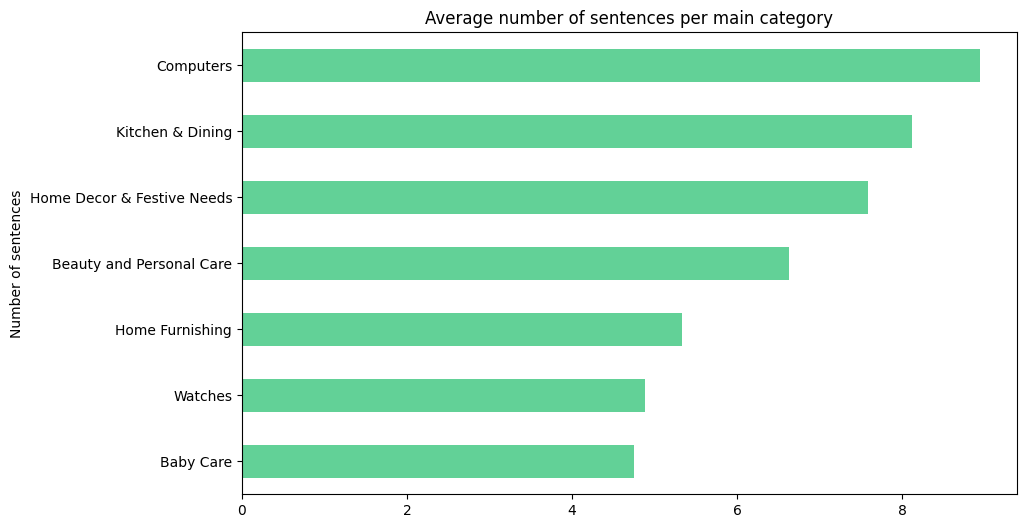

In [21]:
# plot the distribution of the number of sentences per main category ordered by the average number of sentences
# labels should be on the y-axis, and the number of sentences on the x-axis
fig = plt.figure(figsize=(10, 6))
df.groupby('main_category')['description_sentences'].mean().sort_values().plot(kind='barh', color=COLOR)
plt.title('Average number of sentences per main category')
plt.ylabel('Number of sentences')
plt.show()

In [27]:
home = df[df['main_category'] == 'Home Furnishing']


uniq_id  \
0   55b85ea15a1536d46b7190ad6fff8ce7   
3   d4684dcdc759dd9cdf41504698d737d8   
4   6325b6870c54cd47be6ebfbffa620ec7   
33  b85f8843bb1c297dd5712f0bd287006d   
34  a4b09aa7927c59fbb39960b3d7919909   

                                         product_name  \
0   Elegance Polyester Multicolor Abstract Eyelet ...   
3   SANTOSH ROYAL FASHION Cotton Printed King size...   
4   Jaipur Print Cotton Floral King sized Double B...   
33  SANTOSH ROYAL FASHION Cotton Embroidered Diwan...   
34                House This Queen Cotton Duvet Cover   

                                product_category_tree  \
0   ["Home Furnishing >> Curtains & Accessories >>...   
3   ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4   ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
33  ["Home Furnishing >> Living Room Furnishing >>...   
34  ["Home Furnishing >> Bed Linen >> Duvet Covers...   

                                          description  \
0   Key Features of Elegance Polyester Multicolor ...   
3   Key Features of SANTOSH ROYAL FASHION Cotton P...   
4   Key Features of Jaipur Print Cotton Floral Kin...   
33  Key Features of SANTOSH ROYAL FASHION Cotton E...   
34  Key Features of House This Queen Cotton Duvet ...   

                                   image    main_category  description_length  \
0   55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing                1420   
3   d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing                 858   
4   6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing                1197   
33  b85f8843bb1c297dd5712f0bd287006d.jpg  Home Furnishing                 954   
34  a4b09aa7927c59fbb39960b3d7919909.jpg  Home Furnishing                 583   

    description_sentences  
0                      11  
3                       1  
4                       6  
33                      4  
34                      2

### WordCloud

In [22]:
# Count the number of tokens in the description
tokens_count = {}
tokens_frequency = {}
# Using regex to exclude numbers and punctuation
tokenizer = RegexpTokenizer(r'\b\w*[a-zA-Z]+\w*\b|\b[a-zA-Z]+\b')

for _, row in df.iterrows():
    category = row['main_category']
    description = row['description']

    tokens = tokenizer.tokenize(description)

    if category not in tokens_count:
        tokens_count[category] = 0
    tokens_count[category] += len(tokens)

    if category not in tokens_frequency:
        tokens_frequency[category] = {}

    for token in tokens:
        if token not in tokens_frequency[category]:
            tokens_frequency[category][token] = 0
        tokens_frequency[category][token] += 1

# Create a dataframe for the tokens frequency
frequencies = []
for category, tokens in tokens_frequency.items():
    for token, freq in tokens.items():
        frequencies.append({'category':category, 'token':token, 'frequency':freq})

tokens_df = pd.DataFrame(frequencies)
token_count_df = pd.DataFrame(list(tokens_count.items()), columns=['category', 'total_tokens'])

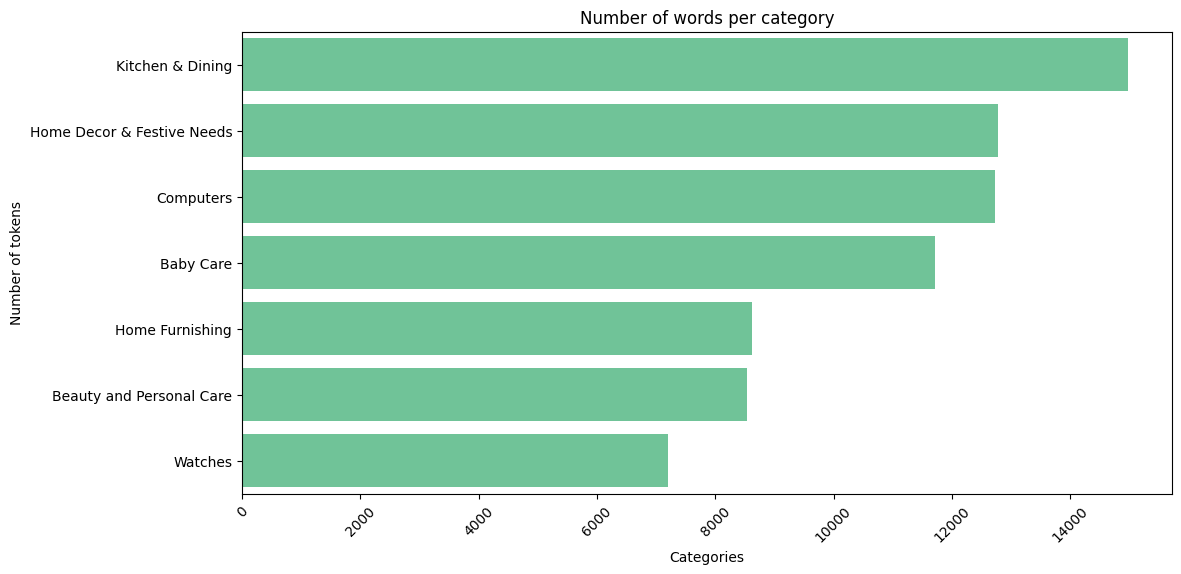

In [28]:
# Plot the number of tokens per category
plt.figure(figsize=(12, 6))
sns.barplot(x='total_tokens', y='category', data=token_count_df.sort_values(by='total_tokens', ascending=False), color=COLOR)
plt.xticks(rotation=45)
plt.title('Number of words per category')
plt.xlabel('Categories')
plt.ylabel('Number of tokens')
plt.show()

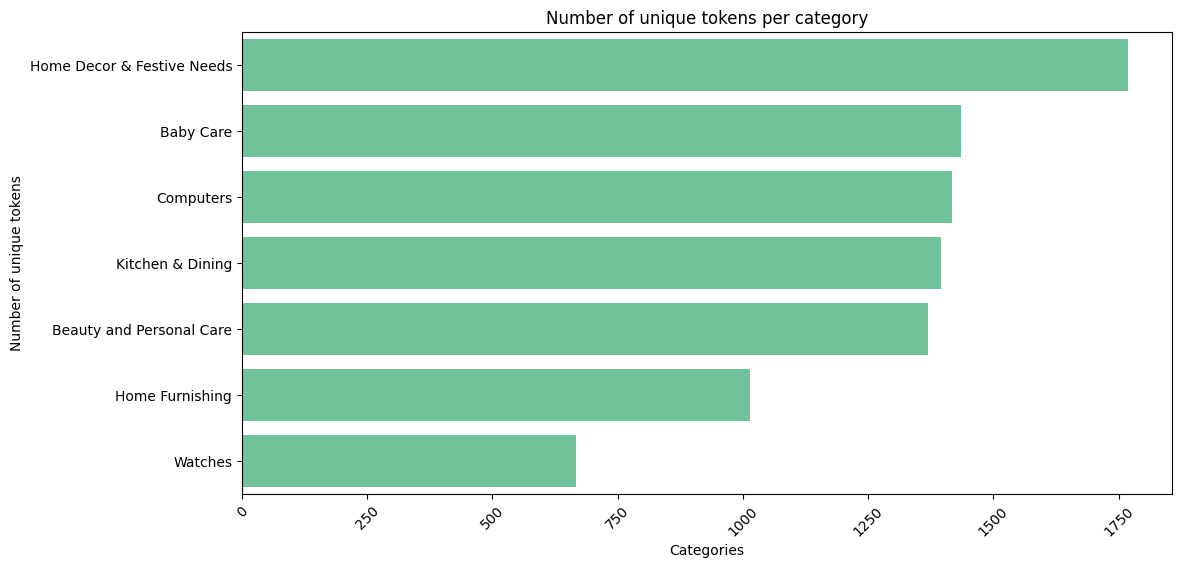

In [34]:
# Group by category to get the unique number of tokens
unique_tokens_count = tokens_df.groupby('category')['token'].count().reset_index()

# Plot the number of unique tokens per category
plt.figure(figsize=(12, 6))
sns.barplot(data=unique_tokens_count.sort_values(by='token', ascending=False), x='token', y='category', color=COLOR)
plt.xticks(rotation=45)
plt.title('Number of unique tokens per category')
plt.xlabel('Categories')
plt.ylabel('Number of unique tokens')
plt.show()

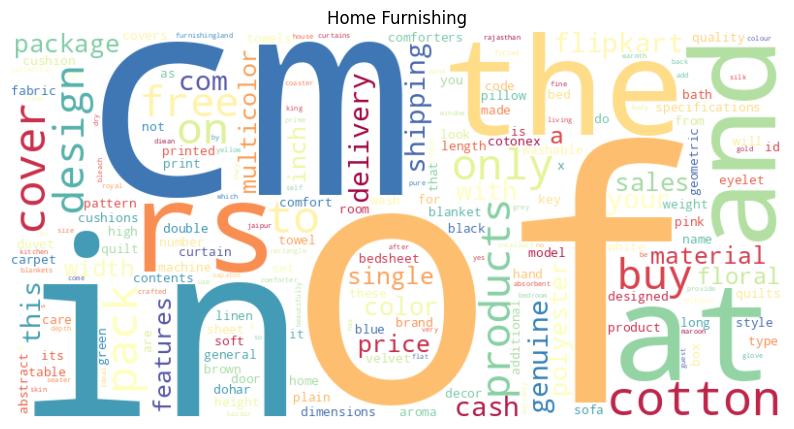

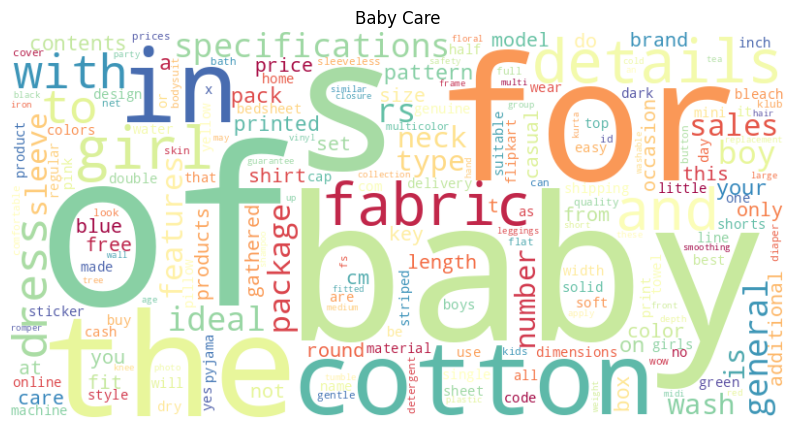

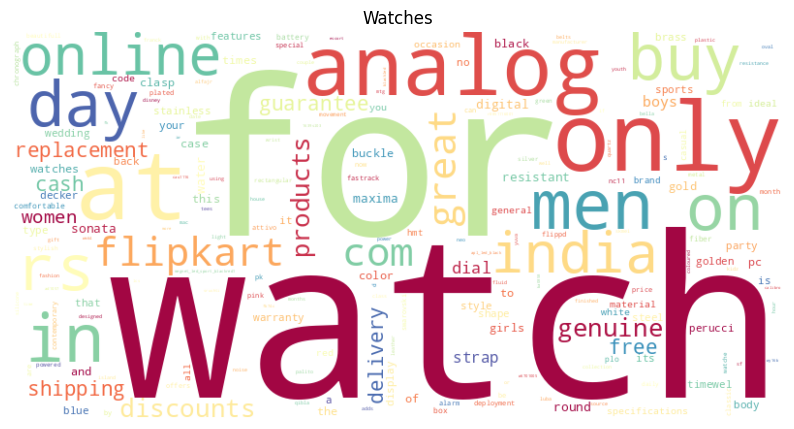

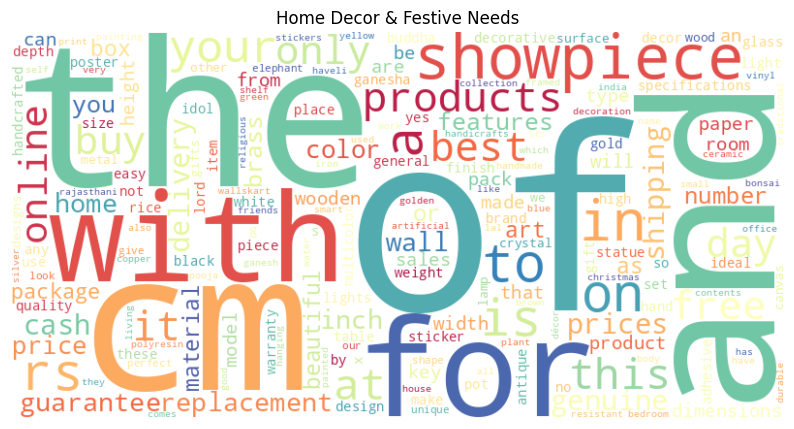

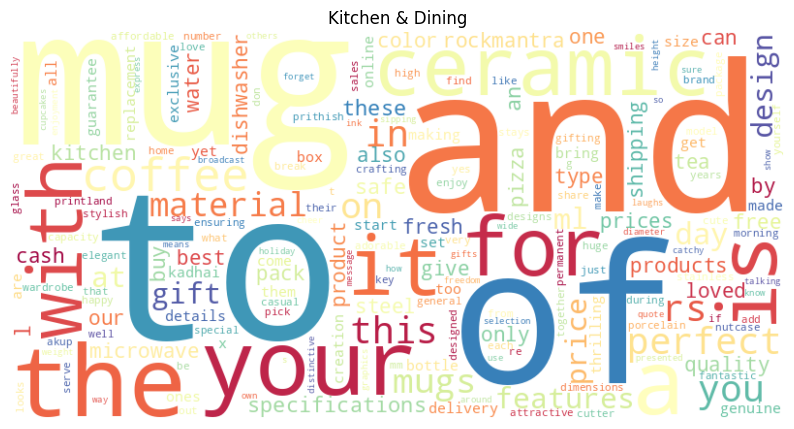

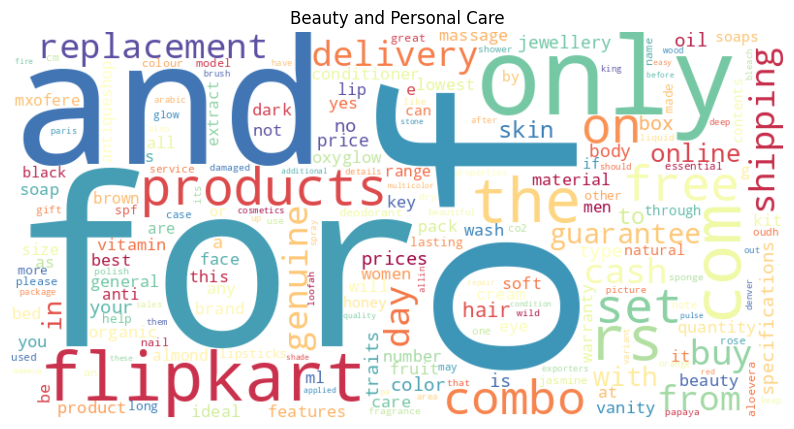

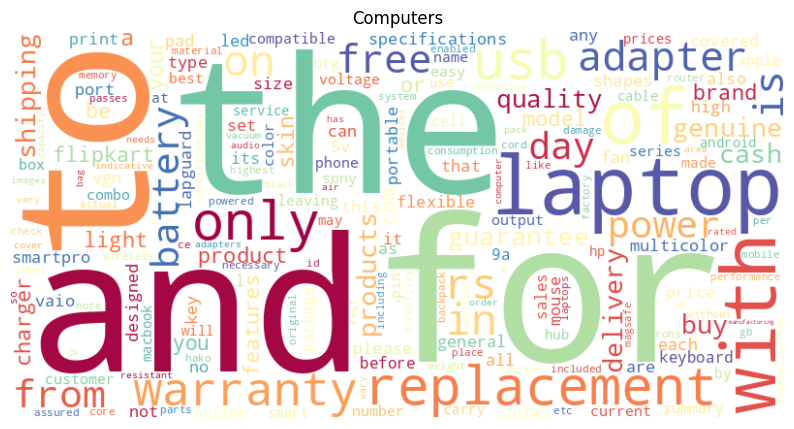

In [35]:
# Plot the WordCloud for each category
for category in tokens_df['category'].unique():
    # Filter on current category
    category_df = tokens_df[tokens_df['category'] == category]

    # Make a dictionnary of words frequency
    token_dict = dict(zip(category_df['token'], category_df['frequency']))

    # Instanciate the WordCloud
    wc = WordCloud(background_color='white', width=800, height=400, colormap='Spectral')
    wc.generate_from_frequencies(token_dict)

    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()

# TEXT PRE-PROCESSING

As we saw in the previous section, we can easily get noise in the data with irrelevant words for the context. We noticed words with empty meaning ('to', 'the', 'and', 'of'...), numbers, white spaces, brands name.
To process natural language, we need to takes some additional steps.
Before we dive into the NLP, let's clarify some vocabulary:
- *Corpus* : Is a collection of documents (here is all the descriptions we have)
- *Document*: Is a sequence of words (here : a product description)
- *Token*: Is a basic unit of discrete data defined to be an item from a vocabulary (here : words)

Preprocessing consists in isolating the most accurate tokens by :
- Getting rid of non-alphabetical charaters, as special characters, numbers (depending on the context)
- Eliminating words with empty meaning (stopwords) or words that are found in several categories.

In [42]:
tokens_number = len(tokens_df['token'].unique())
print(f'There are {tokens_number} unique tokens in the dataset')

There are 5516 unique tokens in the dataset


## Stop words

In [61]:
# Get rid of stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
# Get unique tokens per category
tokens_per_category = tokens_df.groupby('category')['token'].unique().reset_index()
tokens_per_category

category  \
0                   Baby Care   
1    Beauty and Personal Care   
2                   Computers   
3  Home Decor & Festive Needs   
4             Home Furnishing   
5            Kitchen & Dining   
6                     Watches   

                                               token  
0  [specifications, of, sathiyas, cotton, bath, t...  
1  [key, features, of, burt, s, bees, hair, repai...  
2  [key, features, of, d, link, dap1320, qrs, app...  
3  [myesquire, ceramic, burner, pot, lemongrass, ...  
4  [key, features, of, elegance, polyester, multi...  
5  [key, features, of, dungri, india, craft, ducj...  
6  [maserati, time, r8851116001, analog, watch, f...

In [88]:
# Remove stopwords from the tokens
tokens_per_category['filtered_token'] = tokens_per_category['token'].apply(lambda x: [token for token in x if token.lower() not in stopwords])
# get unique tokens for each category
tokens_per_category['filtered_token'] = tokens_per_category['filtered_token'].apply(lambda x: list(set(x)))
tokens_per_category

category  \
0                   Baby Care   
1    Beauty and Personal Care   
2                   Computers   
3  Home Decor & Festive Needs   
4             Home Furnishing   
5            Kitchen & Dining   
6                     Watches   

                                               token  \
0  [specifications, of, sathiyas, cotton, bath, t...   
1  [key, features, of, burt, s, bees, hair, repai...   
2  [key, features, of, d, link, dap1320, qrs, app...   
3  [myesquire, ceramic, burner, pot, lemongrass, ...   
4  [key, features, of, elegance, polyester, multi...   
5  [key, features, of, dungri, india, craft, ducj...   
6  [maserati, time, r8851116001, analog, watch, f...   

                                      filtered_token  
0  [cottion, daughter, maxi, collection, wallmant...  
1  [germs, s0004, fogg, flushed, foolzy, neo, str...  
2  [requirement, germs, corner, voltage, mly2015,...  
3  [requirement, corner, shopping, placing, leaf,...  
4  [fast, 56213kls213, add, padding, height, 75x1...  
5  [cats, fogg, karahi, transparent, collection, ...  
6  [add, height, n1685, wanted, fogg, 317tms317, ...

In [89]:
# Find back the frequency of filtered tokens
filtered_token_frequency_stop = tokens_df[tokens_df['token'].isin(tokens_per_category['filtered_token'].explode())]
filtered_token_frequency_stop

category       token  frequency
0     Home Furnishing         key         32
1     Home Furnishing    features         55
3     Home Furnishing    elegance          5
4     Home Furnishing   polyester         61
5     Home Furnishing  multicolor         54
...               ...         ...        ...
9060        Computers     feather          4
9061        Computers  despicable          4
9063        Computers     looking          4
9064        Computers     upwards          4
9065        Computers        bull          4

[8490 rows x 3 columns]

In [93]:
filtered_tokens_number_stop = len(filtered_token_frequency_stop['token'].unique())
difference = tokens_number - filtered_tokens_number_stop
print(f'There are {filtered_tokens_number_stop} unique tokens in the dataset after removing stopwords')
print(f'The difference is {difference} tokens')

There are 5397 unique tokens in the dataset after removing stopwords
The difference is 119 tokens


## Common words

As the goal is to classify product in categories from description, having same group of words repeating themselves in several categories won't be of any help. 

In addition, words specific to one and only one category are very valuable for the classification.

### Common words to all categories

In [95]:
tokens_per_category

category  \
0                   Baby Care   
1    Beauty and Personal Care   
2                   Computers   
3  Home Decor & Festive Needs   
4             Home Furnishing   
5            Kitchen & Dining   
6                     Watches   

                                               token  \
0  [specifications, of, sathiyas, cotton, bath, t...   
1  [key, features, of, burt, s, bees, hair, repai...   
2  [key, features, of, d, link, dap1320, qrs, app...   
3  [myesquire, ceramic, burner, pot, lemongrass, ...   
4  [key, features, of, elegance, polyester, multi...   
5  [key, features, of, dungri, india, craft, ducj...   
6  [maserati, time, r8851116001, analog, watch, f...   

                                      filtered_token  
0  [cottion, daughter, maxi, collection, wallmant...  
1  [germs, s0004, fogg, flushed, foolzy, neo, str...  
2  [requirement, germs, corner, voltage, mly2015,...  
3  [requirement, corner, shopping, placing, leaf,...  
4  [fast, 56213kls213, add, padding, height, 75x1...  
5  [cats, fogg, karahi, transparent, collection, ...  
6  [add, height, n1685, wanted, fogg, 317tms317, ...

In [96]:
# Get common  tokens to all categories
common_tokens = set(tokens_per_category['filtered_token'].explode().value_counts()[tokens_per_category['filtered_token'].explode().value_counts() == 6].index)
len(common_tokens)

74

In [97]:
# Get common tokens frequency for each category
common_tokens_frequency = filtered_token_frequency_stop[filtered_token_frequency_stop['token'].isin(common_tokens)]
common_tokens_frequency

category       token  frequency
5     Home Furnishing  multicolor         54
11    Home Furnishing          cm        188
33    Home Furnishing       metal          3
50    Home Furnishing        home         42
59    Home Furnishing        sure          1
...               ...         ...        ...
8785        Computers      prices         24
8901        Computers         set         33
8959        Computers       table          2
8976        Computers      colour          2
9011        Computers      inches         30

[444 rows x 3 columns]

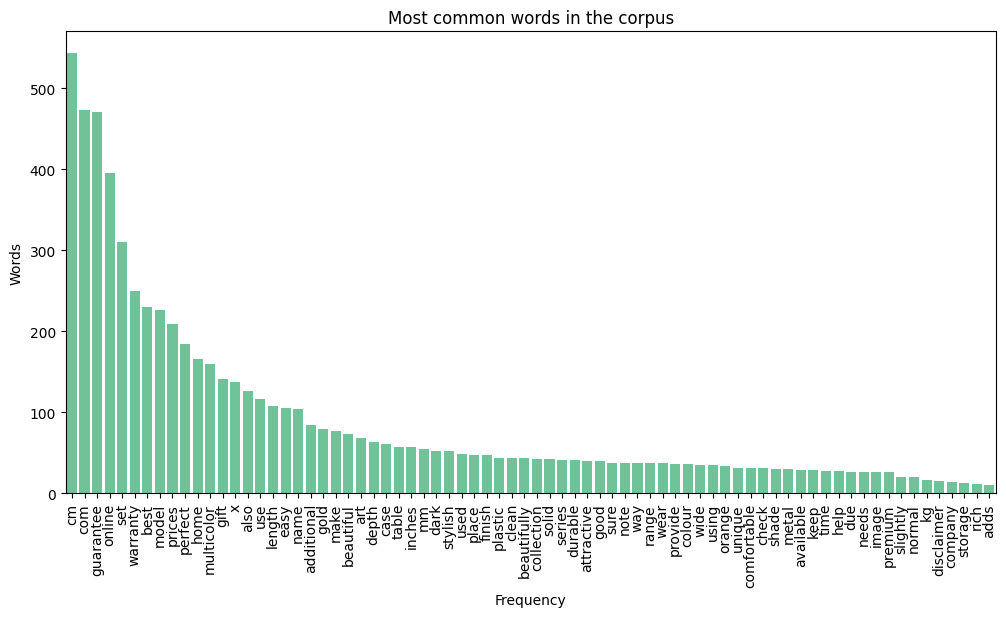

In [113]:
# Frequency of each words in the corpus
corpus_common_token = common_tokens_frequency.groupby('token')['frequency'].sum().sort_values(ascending=False)
# Plot the most common words in the corpus
plt.figure(figsize=(12, 6))
sns.barplot(x='token', y='frequency', color=COLOR, data=corpus_common_token.reset_index())
plt.title('Most common words in the corpus')
plt.xticks(rotation=90)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Common words of the corpus don't seem to give relevant indication for a classification. We decide to drop these words. In the same approach, we will consider that words present in at least half of the categories won't help us in the classification.

In [117]:
# count the number of categories in which each token appears
tokens_count = filtered_token_frequency_stop['token'].value_counts()
token_common_to_at_least_3_cat = tokens_count[tokens_count >= 3].index.tolist()
len(token_common_to_at_least_3_cat)

745

In [122]:
# Keep only tokens that appear in at less than 3 categories
selected_tokens = filtered_token_frequency_stop[~filtered_token_frequency_stop['token'].isin(token_common_to_at_least_3_cat)]
selected_tokens['token'].value_counts()

token
understanding    2
leather          2
movement         2
quartz           2
swiss            2
                ..
haveli           1
rajasthani       1
chowkidar        1
statues          1
bull             1
Name: count, Length: 4652, dtype: int64

### Word cloud after common words filtering

In [123]:
selected_tokens

category       token  frequency
7     Home Furnishing      eyelet         44
9     Home Furnishing     curtain         42
21    Home Furnishing   interiors          7
31    Home Furnishing      stitch          2
38    Home Furnishing    romantic          1
...               ...         ...        ...
9059        Computers     peacock          4
9060        Computers     feather          4
9061        Computers  despicable          4
9064        Computers     upwards          4
9065        Computers        bull          4

[5356 rows x 3 columns]

In [126]:
# number of unique tokens
unique_tokens = len(selected_tokens['token'].unique())
print(f'There are {unique_tokens} unique tokens in the dataset after removing common tokens')

There are 4652 unique tokens in the dataset after removing common tokens


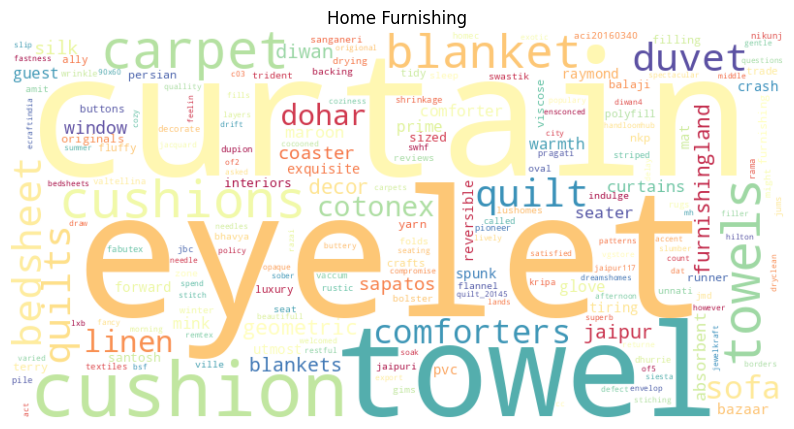

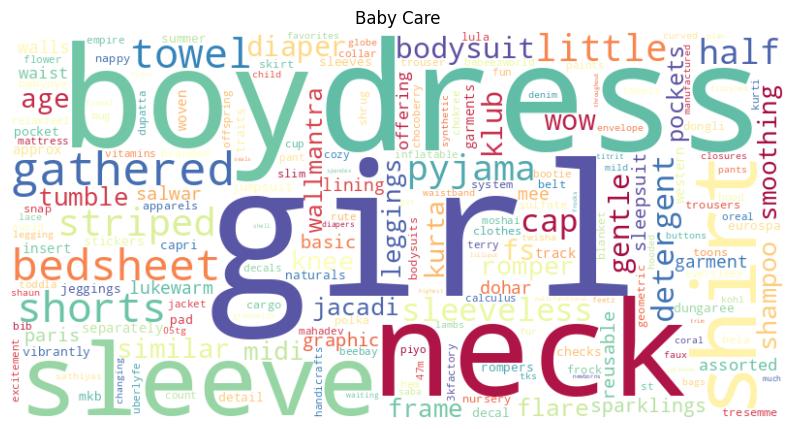

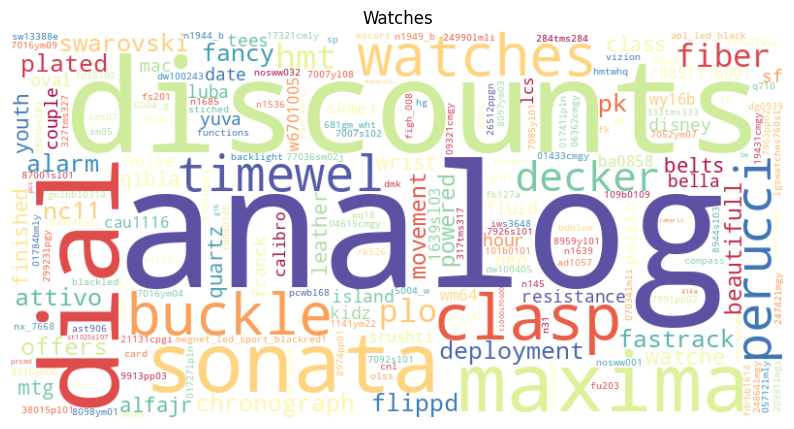

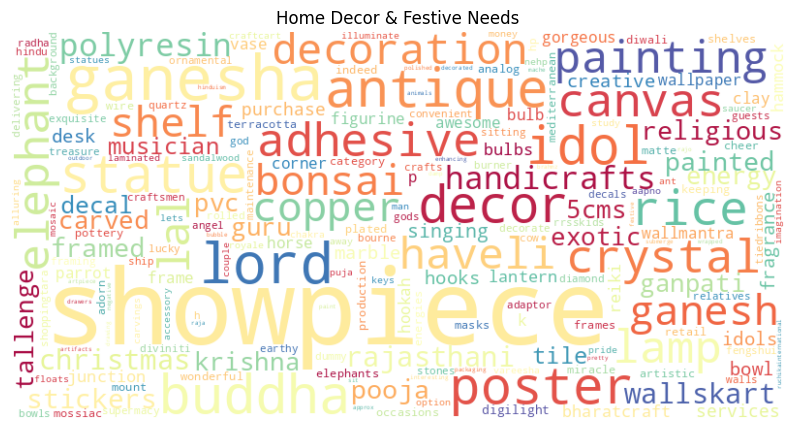

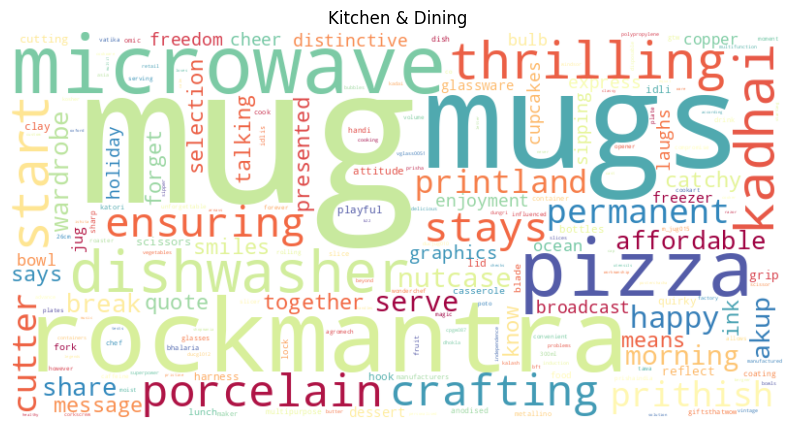

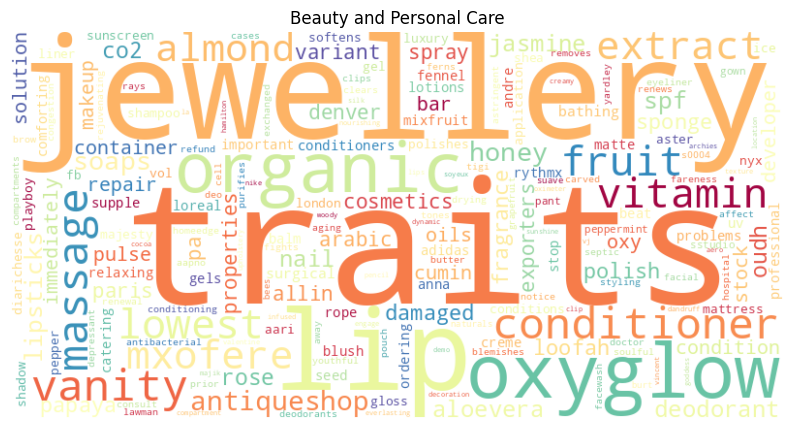

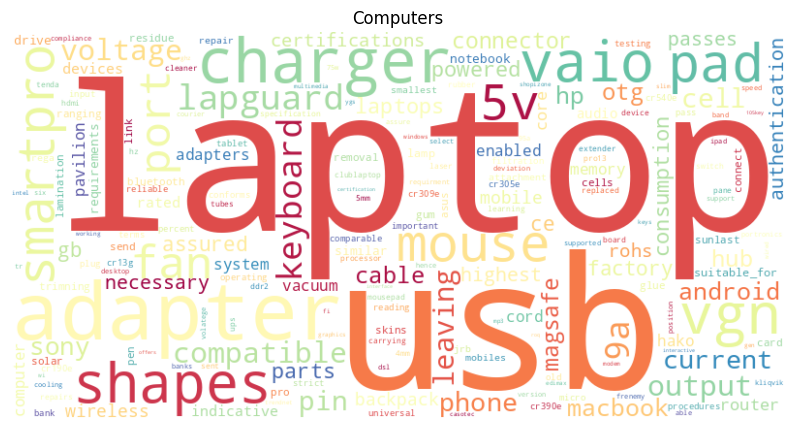

In [125]:
for cat in selected_tokens['category'].unique():
    # Filter on current category
    category_df = selected_tokens[selected_tokens['category'] == cat]

    # Make a dictionnary of words frequency
    token_dict = dict(zip(category_df['token'], category_df['frequency']))

    # Instanciate the WordCloud
    wc = WordCloud(background_color='white', width=800, height=400, colormap='Spectral')
    wc.generate_from_frequencies(token_dict)

    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(cat)
    plt.show()

Observing left tokens, we notice that words can be similar. This is obvious in Kitchen & Dining category where ones of most frequent tokens are mug and mugs. In Natural Language Processing, we have several methods to limit words to tehir root or most common basis and this will be our next step.

### List of stopwords

In [127]:
print(f'Number of english language stopwords: {len(stopwords)}')
print(f'Number of tokens in all categories: {len(common_tokens)}')
print(f'Number of tokens in at least 3 catgories: {len(token_common_to_at_least_3_cat)}')

Number of english language stopwords: 179
Number of tokens in all categories: 74
Number of tokens in at least 3 catgories: 745


## Words reduction

In Natural Language Processing, there are several ways to reduce a word to its essence :
- *Stemming* : Consists in getting rid of the prefixes and suffixes
- *Lemmatization*: Fonds words root

Using these methods will help in reducing the data in the corpus and lower the noise send to the model. The model will then become more robust and data will have more uniformity.

### Stemming

Removes the suffix of a word based on the assumption that different word forms consist of a stem and an ending. It does not care if the root is a real word or not.

These methods have the advantage to be fast to compute.

The most common method is to use the Porter Stemming Algorithm. It removes the suffixes from an English word and obtain its stem.

However,it exists a better version of the Porter Stemming Algorithm that fix some issues of the first version : Snowball Stemmer. The Snowball Stemming is more aggressive thant Porter Stemmer.

Drawbacks of Stemmings :
- overstemming or understemming may lead to inappropriate, unmeaningful stems
- does not consider the way the word is used in the sentence and could be a verb or a noun depending on the context (ex: 'saw')

In [133]:
def stem_tokens(tokens: list[str], stemmer) -> list[str]:
    """ Stem a list of tokens using a stemmer
    Args:
        tokens (list): list of tokens
        stemmer (object): stemmer object
    Returns:
        list: list of stemmed tokens
    """
    # Instanciate the stemmer
    stemmer = stemmer
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [137]:
tokens_per_category['stemmed_token'] = tokens_per_category.apply(lambda x: stem_tokens(x['filtered_token'], SnowballStemmer('english')), axis=1)
# get unique tokens for each category
tokens_per_category['stemmed_token'] = tokens_per_category['stemmed_token'].apply(lambda x: list(set(x)))
# Get a list of all unique stemmed tokens
stemmed_tokens = tokens_per_category['stemmed_token'].explode().unique()
print(f'There are {len(stemmed_tokens)} unique stemmed tokens in the dataset')

There are 4400 unique stemmed tokens in the dataset


### Lemmatization

Similar to stemming, it is a smarter algorithm as it results in understandable root forms. A *lemma* is the *canonical form* of a word.